**CATEGORIZING RESUMES INTO VARIOUS OCCUPATIONS**

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py", out="helper_prabowo_ml.py")
from helper_prabowo_ml import (
    clean_html,
    remove_links,
    remove_special_characters,
    removeStopWords,
    remove_,
    remove_digits,
    lower,
    email_address,
    non_ascii,
    punct,
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


DATASET

In [2]:
df = pd.read_csv("resume-categories.csv")
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [3]:
print("Total number of jobs:", df.Category.nunique())
max_resume_len = 200

Total number of jobs: 25


In [4]:
labels_dict = {}
for idx, label in enumerate(df.Category.unique()):
    labels_dict[label] = idx
print(labels_dict)
df.Category = df.Category.apply(func=lambda x: labels_dict[x])
df.Category = df.Category.astype(np.int64)

{'Data Science': 0, 'HR': 1, 'Advocate': 2, 'Arts': 3, 'Web Designing': 4, 'Mechanical Engineer': 5, 'Sales': 6, 'Health and fitness': 7, 'Civil Engineer': 8, 'Java Developer': 9, 'Business Analyst': 10, 'SAP Developer': 11, 'Automation Testing': 12, 'Electrical Engineering': 13, 'Operations Manager': 14, 'Python Developer': 15, 'DevOps Engineer': 16, 'Network Security Engineer': 17, 'PMO': 18, 'Database': 19, 'Hadoop': 20, 'ETL Developer': 21, 'DotNet Developer': 22, 'Blockchain': 23, 'Testing': 24}


In [5]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [6]:
df['resume_len'] = df.Resume.apply(len)
df = text_preprocess(df,'Resume')
data = df[['Resume', 'Category']]
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Resume'], data['Category'], test_size=0.2, random_state=42
)
df.head()

,Category,Resume,resume_len
0,0,skills programming languages python pandas num...,4786
1,0,education details may may b e uitrgpv data sci...,1268
2,0,areas interest deep learning control system de...,1871
3,0,skills r python sap hana tableau sap hana sql ...,6995
4,0,education details mca ymcaust faridabad haryan...,452


TRAINING

In [7]:
# BERT Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=data['Category'].nunique())

def tokenize_function(examples):
    return tokenizer(examples['Resume'], truncation=True, padding='max_length', max_length=512)

train_dataset = Dataset.from_dict({'Resume': train_texts, 'Category': train_labels})
test_dataset = Dataset.from_dict({'Resume': test_texts, 'Category': test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column('Category', 'labels')
test_dataset = test_dataset.rename_column('Category', 'labels')

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/769 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

In [8]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    save_strategy='epoch',
    save_total_limit=2,
    logging_steps=10,
    report_to=["none"]
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

In [9]:
print("Min label in training set:", train_labels.min())
print("Max label in training set:", train_labels.max())
print("Min label in test set:", test_labels.min())
print("Max label in test set:", test_labels.max())
print("Number of labels in the model:", model.config.num_labels)

Min label in training set: 0
Max label in training set: 24
Min label in test set: 0
Max label in test set: 24
Number of labels in the model: 25


In [13]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.501100,2.309701
2,1.600500,1.350100
3,0.749900,0.687184
4,0.428400,0.322427
5,0.197700,0.163323
6,0.117800,0.095515
7,0.073900,0.068598
8,0.059000,0.056255
9,0.050200,0.051254
10,0.055000,0.049092


TrainOutput(global_step=970, training_loss=0.7034325526547186, metrics={'train_runtime': 925.516, 'train_samples_per_second': 8.309, 'train_steps_per_second': 1.048, 'total_flos': 2023741847746560.0, 'train_loss': 0.7034325526547186, 'epoch': 10.0})

In [15]:
torch.save(model.state_dict(), "fine-tuned_BERT_resume-classification.pt")

TESTING

In [10]:
model.load_state_dict(torch.load("fine-tuned_BERT_resume-classification.pt", map_location=torch.device('cpu')))
model.eval()

print("Number of labels in the model:", model.config.num_labels)

# Evaluate the model
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_16572\2811623570.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine-tuned_BERT_resume-classi

Number of labels in the model: 25


  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
idx_to_category = {value: key for key, value in labels_dict.items()}
print(idx_to_category)

{0: 'Data Science', 1: 'HR', 2: 'Advocate', 3: 'Arts', 4: 'Web Designing', 5: 'Mechanical Engineer', 6: 'Sales', 7: 'Health and fitness', 8: 'Civil Engineer', 9: 'Java Developer', 10: 'Business Analyst', 11: 'SAP Developer', 12: 'Automation Testing', 13: 'Electrical Engineering', 14: 'Operations Manager', 15: 'Python Developer', 16: 'DevOps Engineer', 17: 'Network Security Engineer', 18: 'PMO', 19: 'Database', 20: 'Hadoop', 21: 'ETL Developer', 22: 'DotNet Developer', 23: 'Blockchain', 24: 'Testing'}


Accuracy: 0.9948

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         9
           9       1.00      1.00      1.00        15
          10       0.80      1.00      0.89         4
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00        12
          15       1.00      1.00      1.00        10
          16       1.00      0.93      

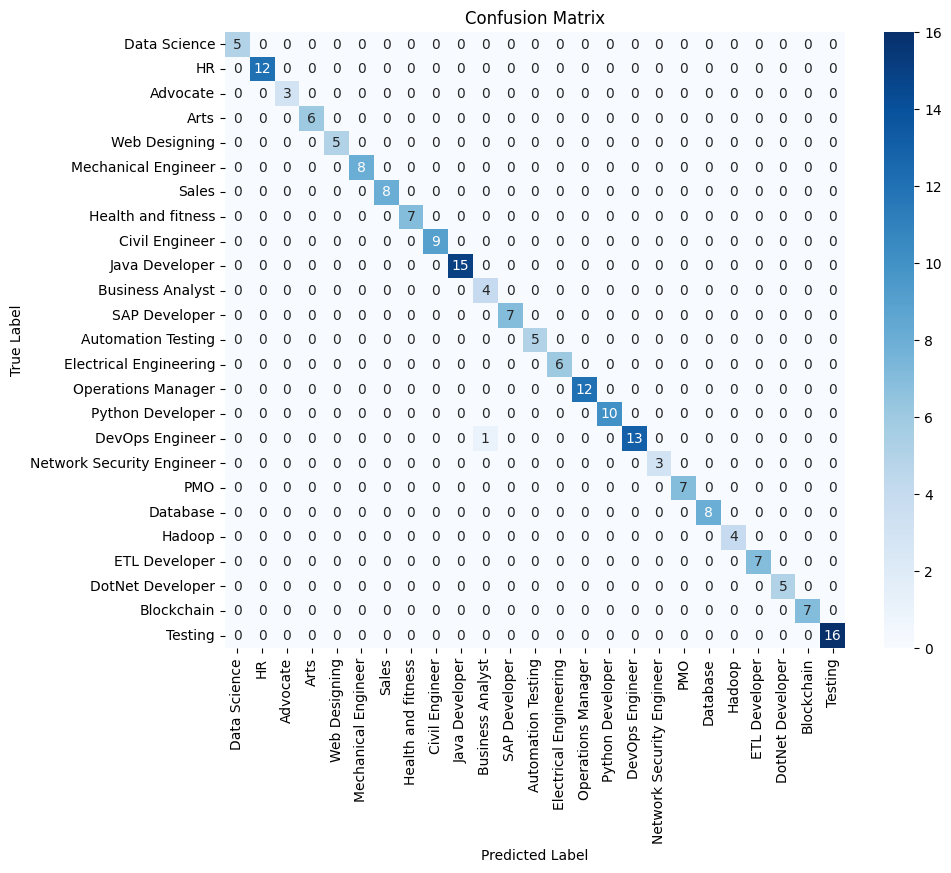

In [13]:
# Accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Classification Report
print(f"\nClassification report:\n")
print(classification_report(test_labels, predicted_labels.numpy()))

# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print('\nConfusion Matrix:')
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(idx_to_category)) + 0.5, list(idx_to_category.values()), rotation=90)
plt.yticks(np.arange(len(idx_to_category)) + 0.5, list(idx_to_category.values()), rotation=0)
plt.show()

USER INPUT

In [31]:
def test_user_input(user_input, model, tokenizer, labels_dict):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    inputs = tokenizer(user_input, return_tensors='pt', padding=True, truncation=True, max_length=512)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    predicted_class = torch.argmax(logits, dim=-1)
    predicted_label = list(labels_dict.keys())[predicted_class.item()]
    return predicted_label

user_input = "ai ml"
model.load_state_dict(torch.load("fine-tuned_BERT_resume-classification.pt", map_location=torch.device('cpu')))
model.eval()
predicted_label = test_user_input(user_input, model, tokenizer, labels_dict)
print(f"Predicted category: {predicted_label}")

C:\Users\hp\AppData\Local\Temp\ipykernel_1408\1293481233.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fine-tuned_BERT_resume-classi

Predicted category: HR
